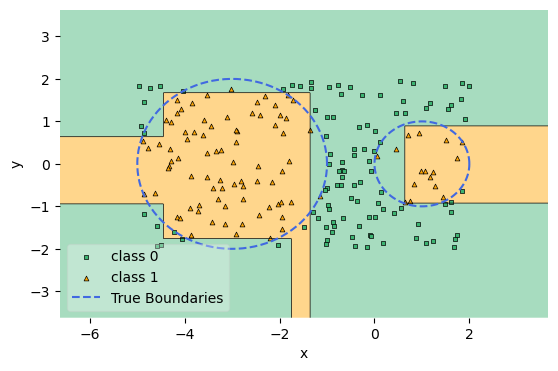

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions

def in_circle1(point):
    x, y = point
    return (x+3)**2 + y**2 <= 2**2

def in_circle2(point):
    x, y = point
    return (x-1)**2 + y**2 <= 1**2

np.random.seed(0)
n = 200
# Generate n random data points uniformly distributed in the box [-2, 2] x [-2, 2]
data_points = np.column_stack((np.random.uniform(-5, 2, n), np.random.uniform(-2, 2, n)))
labels = [1 if in_circle1(point) or in_circle2(point) else 0 for point in data_points]
labels = np.array(labels)
data = pd.DataFrame(data_points, columns=['x', 'y'])
data['label'] = labels

tree = DecisionTreeClassifier(max_depth=4)  # You can adjust the depth of the tree here
tree.fit(data_points, labels)

# 3. Visualize the tree on the 2D plane
plt.figure(figsize=(6.3, 4))
scatter_kwargs = {'s': 12, 'edgecolor': 'black',\
                  'alpha': 1, 'lw': 0.5}

ax = plot_decision_regions(data_points, labels, clf=tree, 
                      scatter_kwargs=scatter_kwargs,zoom_factor = 0.6,
                      legend=2, colors='mediumseagreen,orange')

# Plot the eps
trueCenter1 = -3
trueCenter2 = 1
trueR1 = 2
trueR2 = 1
t = np.linspace(0, 2*np.pi, 100)
ax.plot(trueCenter1+trueR1*np.cos(t) , trueR1*np.sin(t),\
        label = 'True Boundaries', linestyle = 'dashed', color = 'royalblue')
ax.plot(trueCenter2+trueR2*np.cos(t), trueR2*np.sin(t),\
     linestyle = 'dashed', color = 'royalblue')
#plt.title('Decision Tree (CART) Decision Boundaries')
plt.xlabel('x')
plt.ylabel('y')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['class 0', 'class 1', 'True Boundaries'],framealpha=0.3, scatterpoints=1,loc='lower left')
#plt.show()
plt.savefig('CARTboundary.pdf')


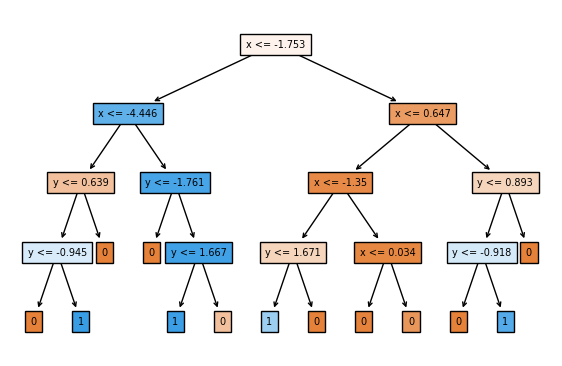

In [141]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
plt.figure(figsize=(7,4.5))
tree_plot = plot_tree(tree, filled=True, feature_names=data.columns, class_names=['0','1'],\
impurity=False, fontsize=7)

# Customize labels manually to show only the feature and threshold
for node in tree_plot:
    text = node.get_text()
    if 'samples =' in text:  # Check if the node is not a leaf
        # Find the line with the feature and threshold
        lines = text.split('\n')
        for line in lines:
            if '<=' in line or '>' in line:
                node.set_text(line)  # Set text to only feature and threshold
                break
        text = node.get_text()
        if 'class' in text:
            node.set_text(lines[-1][-1])  # Display only the class name in leaf nodes

plt.savefig('CARTstructure.pdf')
#plt.show()

In [124]:
np.random.seed(1)
n = 200
# Generate n random data points uniformly distributed in the box [-2, 2] x [-2, 2]
data_points = np.column_stack((np.random.uniform(-5, 2, n), np.random.uniform(-2, 2, n)))
labels = [1 if in_circle1(point) or in_circle2(point) else 0 for point in data_points]
labels = np.array(labels)
df = pd.DataFrame(data_points, columns=['x', 'y'])
df['label'] = labels
tree.score(df[df.columns[:-1]], df[df.columns[-1]])


C:\Users\MSI-NB\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


0.89

In [2]:
data.insert(loc=0, column='x2', value=data['x']*data['x'])
data.insert(loc=0, column='y2', value=data['y']*data['y'])
data.insert(loc=0, column='xy', value=data['x']*data['y'])

In [3]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB, quicksum
def complete_tree_edges(n):
    edges = []
    for i in range(n):
        left_child = 2 * i + 1
        right_child = 2 * i + 2
        if left_child <= n:
            edges.append((i, left_child))
        if right_child <= n:
            edges.append((i, right_child))
    return edges
def at(t):
    if t % 2 == 1:
        return int((t-1)/2)
    else:
        return int((t-2)/2)

def lt(t):
    return 2*t + 1
def rt(t):
    return 2*t + 2

In [4]:
K = set(data['label'].tolist())
I = [i for i in range(len(data))]
J = [j for j in range(len(data.columns)-1)]
countDict = {}
for k in K:
    countDict[k] = 0
for i in I:
    countDict[data['label'][i]] += 1
alpha = 0
beta = 0
sigma = 2
Lhat = len(I)-max(countDict.values())
mu = 1e-4
N = [t for t in range(np.power(2, sigma)-1)]
L = [l for l in range(len(N), len(N)+np.power(2, sigma))]
s_node = -1
w_node = L[-1]+1
edges = complete_tree_edges(L[-1])
edges = edges + [(-1, 0)]
edges = edges + [(t, w_node) for t in N+L]

In [5]:
C = 6

In [6]:
OCTH = gp.Model()
ahat = OCTH.addVars(J,N, vtype = GRB.CONTINUOUS, lb=0, ub =1)
a = OCTH.addVars(J,N, vtype = GRB.CONTINUOUS, lb=-1, ub =1)
b = OCTH.addVars(N, vtype = GRB.CONTINUOUS, lb = -GRB.INFINITY)
d = OCTH.addVars(N, vtype = GRB.BINARY)
s = OCTH.addVars(J, N, vtype = GRB.BINARY)
g = OCTH.addVars(K, N+L, vtype = GRB.BINARY)
u = {}
for i in I:
    for edge in edges:
        u[i, edge] = OCTH.addVar(vtype=GRB.BINARY)


OCTH.addConstrs(quicksum(ahat[j,t] for j in J) <= d[t] for t in N)
OCTH.addConstrs(-ahat[j,t]<= a[j,t] for j in J for t in N)
OCTH.addConstrs(a[j,t] <= ahat[j,t] for j in J for t in N)
OCTH.addConstrs(-s[j,t]<= a[j,t] for j in J for t in N)
OCTH.addConstrs(a[j,t] <= s[j,t] for j in J for t in N)
OCTH.addConstrs(s[j,t] <= d[t] for j in J for t in N)
OCTH.addConstrs(quicksum(s[j,t] for j in J) >= d[t] for t in N)
OCTH.addConstrs(-d[t] <= b[t] for t in N)
OCTH.addConstrs(b[t] <= d[t] for t in N)
OCTH.addConstrs(quicksum(g[k,l] for k in K) ==1 for l in L)
OCTH.addConstrs(u[i,(at(t), t)] == 
                u[i, (t, lt(t))] + u[i, (t, rt(t))] + u[i, (t, w_node)] for t in N[1:] for i in I)
OCTH.addConstrs(u[i,(-1, 0)] == 
                u[i, (0, lt(0))] + u[i, (0, rt(0))] + u[i, (0, w_node)] for i in I)
OCTH.addConstrs(u[i, (at(l),l)] == u[i, (l, w_node)] for l in L for i in I)
OCTH.addConstrs(u[i, (t, w_node)] <= g[data['label'][i], t] for i in I for t in N+L)
OCTH.addConstrs(d[t] + quicksum(g[k,t] for k in K) == 1 for t in N)
OCTH.addConstrs(quicksum(a[j,t]*data[data.columns[j]][i] for j in J) + mu <= 
               b[t] + (2+mu)*(1-u[i, (t, lt(t))]) for t in N for i in I)
OCTH.addConstrs(quicksum(a[j,t]*data[data.columns[j]][i] for j in J) >= 
               b[t] - 2*(1-u[i,(t, rt(t))]) for t in N for i in I)
OCTH.addConstrs(u[i, (t, lt(t))] <= d[t] for i in I for t in N)
OCTH.addConstrs(u[i, (t, rt(t))] <= d[t] for i in I for t in N)
OCTH.addConstr(quicksum(s[j,t] for j in J for t in N)<=C)

OCTH.setObjective(1/Lhat *(len(I) - quicksum(u[i, (s_node, 0)] for i in I)) + 
                  alpha * quicksum(s[j,t] for j in J for t in N), GRB.MINIMIZE)
OCTH.Params.TimeLimit = 100

Set parameter TimeLimit to value 100


In [7]:
OCTH.optimize()
OCTH.update()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5295 rows, 2865 columns and 17830 nonzeros
Model fingerprint: 0xf6c648f5
Variable types: 33 continuous, 2832 integer (2832 binary)
Coefficient statistics:
  Matrix range     [1e-07, 2e+01]
  Objective range  [1e-02, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 2.1052632
Presolve removed 804 rows and 1004 columns
Presolve time: 0.03s
Presolved: 4491 rows, 1861 columns, 16016 nonzeros
Variable types: 33 continuous, 1828 integer (1828 binary)
Found heuristic solution: objective 1.0000000

Root relaxation: objective -8.881784e-16, 1292 iterations, 0.05 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Une

In [8]:
quicksum(s[j,t].x for j in J for t in N)

<gurobi.LinExpr: 6.0>

In [9]:
lines = []
for t in N:
    if d[t].x>0.5:
        line = []
        for j in J:
            print(t, a[j,t].x)
            line.append(a[j,t].x)
        print(b[t].x)
        line.append(b[t].x)
        lines.append(line)

0 0.0
0 0.08367405121538495
0 0.08291744420475307
0 0.4952793527924158
0 0.0
-0.40185103096781705
2 0.0
2 -0.041831337033335456
2 -0.05350244897285808
2 0.1073918439004798
2 0.0
0.004398322508579459


In [10]:
b1 = (0.4952793527924158)/(2*np.sqrt(0.08291744420475307))
center1 = - (b1)/np.sqrt(0.08367405121538495)
r1_temp = -0.4 + b1**2
r1a = np.sqrt(r1_temp/0.08291744420475307)
r1b = np.sqrt(r1_temp/0.08367405121538495)

In [69]:
center1

-2.973047691745581

In [70]:
r1a

2.023756812855084

In [71]:
r1b

2.0145863132772908

In [11]:
data.columns

Index(['xy', 'y2', 'x2', 'x', 'y', 'label'], dtype='object')

In [65]:
b2 = (-0.1073918439004798)/(2*np.sqrt(0.05350244897285808))
center2 = -(b2)/np.sqrt(0.041831337033335456)
r2_temp = -0.004398322508579459 + b2**2
r2a = np.sqrt(r2_temp/0.05350244897285808)
r2b = np.sqrt(r2_temp/0.041831337033335456)

In [66]:
center2=center2-0.11

In [68]:
center2

1.025020223739891

In [72]:
r2a

0.9617887021426037

In [73]:
r2b

1.0877162807054768

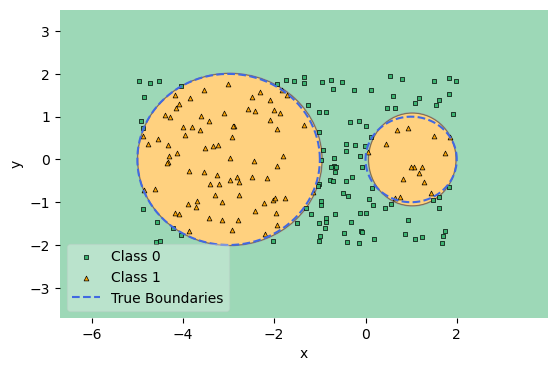

In [146]:
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

backalpha1 = 0.5
backalpha2 = 0.5
# Plotting
fig, ax = plt.subplots(figsize=(6.3,4))
color_rgba = mcolors.to_rgba('mediumseagreen', alpha=backalpha1)  # Set alpha to 0.5

ax.set_facecolor(color_rgba)
ellipse11 = Ellipse((center1, 0), width=2*r1a, height=2*r1b, 
                  angle=0, color='white', alpha=1)
ax.add_patch(ellipse11)
ellipse22 = Ellipse((center2, 0), width=2*r2a, height=2*r2b, 
                  angle=0, color='white', alpha=1)
ax.add_patch(ellipse22)

ellipse1 = Ellipse((center1, 0), width=2*r1a, height=2*r1b, 
                  angle=0, facecolor='orange', alpha=backalpha2, edgecolor='black', linewidth=1)
ax.add_patch(ellipse1)
ellipse2 = Ellipse((center2, 0), width=2*r2a, height=2*r2b, 
                  angle=0, facecolor='orange', alpha=backalpha2, edgecolor='black', linewidth=1)
ax.add_patch(ellipse2)

# Differentiating point types by label
for label, group in data.groupby('label'):
    if label == 1:
        ax.scatter(group['x'], group['y'], marker='^',\
                   lw = 0.5, s=12, color = 'orange', edgecolors='black', label='Class 1')
    else:
        ax.scatter(group['x'], group['y'], marker='s',\
                   lw = 0.5, s=12, color = 'mediumseagreen',edgecolors='black', label= 'Class 0')


#ax.scatter(group['x'], group['y'], label=f'Inside Circle ({label})' if label == 1 else f'Outside Circle ({label})',
#               color='orange' if label == 1 else 'mediumseagreen')
# Plot the eps
trueCenter1 = -3
trueCenter2 = 1
trueR1 = 2
trueR2 = 1
t = np.linspace(0, 2*np.pi, 100)
ax.plot(trueCenter1+trueR1*np.cos(t) , trueR1*np.sin(t),\
        label = 'True Boundaries', linestyle = 'dashed', color = 'royalblue')
ax.plot(trueCenter2+trueR2*np.cos(t), trueR2*np.sin(t),\
     linestyle = 'dashed', color = 'royalblue')

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(-6.7, 3.9999)
ax.set_ylim(-3.7, 3.5)
ax = plt.gca()  # 获取当前的Axes对象
ax.spines['top'].set_visible(False)    # 关闭上边框
ax.spines['right'].set_visible(False)  # 关闭右边框
ax.spines['left'].set_visible(False)   # 关闭左边框
ax.spines['bottom'].set_visible(False) # 关闭下边框
# Add labels, legend, and title
#plt.title('Nonlinear Decision Tree Decision Boundaries')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=0.3, scatterpoints=1, loc = 'lower left')

# Show plot
#plt.show()
plt.savefig('OCTNHboundary.pdf')

In [127]:
np.random.seed(1)
n = 200
# Generate n random data points uniformly distributed in the box [-2, 2] x [-2, 2]
data_points = np.column_stack((np.random.uniform(-5, 2, n), np.random.uniform(-2, 2, n)))
labels = [1 if in_circle1(point) or in_circle2(point) else 0 for point in data_points]
labels = np.array(labels)
df = pd.DataFrame(data_points, columns=['x', 'y'])
df['label'] = labels


In [128]:
df.insert(loc=0, column='x2', value=df['x']*df['x'])
df.insert(loc=0, column='y2', value=df['y']*df['y'])
df.insert(loc=0, column='xy', value=df['x']*df['y'])

In [133]:
class temp:
    pass
OCTHmodel = temp()
OCTHmodel.N = N
OCTHmodel.K = K
OCTHmodel.J = J
OCTHmodel.I = I
OCTHmodel.L = L


In [137]:
import os
import sys
src_path = os.path.abspath('src')
sys.path.append(src_path)
from Trees import CustomDecisionTreeClassifier

clf = CustomDecisionTreeClassifier(a, b, d, g, OCTHmodel)

In [139]:
clf.score(df[df.columns[:-1]],df[df.columns[-1]])

0.99